# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

#Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, dobicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

Files already downloaded and verified


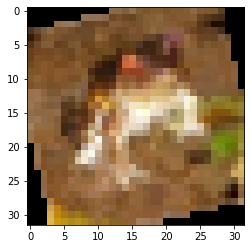

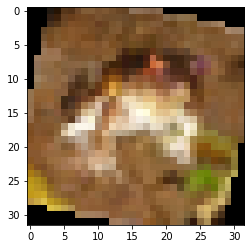

In [2]:
import torch
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torchvision


transform = transforms.Compose([
    transforms.RandomRotation(30),                        
    transforms.ToTensor()
])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from typing import Tuple
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def split_train_data(train_data) -> Tuple[Subset, Subset]:
    train_idx, dev_idx = train_test_split(
        torch.arange(len(train_data)),
        test_size=0.2, stratify=train_data.targets,
        random_state=1
    )
    train = Subset(train_data, train_idx)
    dev = Subset(train_data, dev_idx)
    return train, dev 

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader,test_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in train_dl:
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )       
    
  y_true = []
  y_pred = []
  for X_test, y_test in test_dl:
    y_true.extend(y_test)
    y_pred.extend(torch.argmax(model(X_test.cuda()).cpu(),dim=1))
  
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  f1score = f1_score(y_true, y_pred, average='weighted')

  print(f'[DONE] F1 score for test set: {f1score}')
  return f1score

def get_loaders(train_transform):
  test_transform = torchvision.transforms.ToTensor()
  train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=train_transform, download=True)
  test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=test_transform, train=False, download=True)

  train, dev = split_train_data(train_ds)

  train_loader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=True)
  dev_loader = DataLoader(dev, batch_size=32, pin_memory=True)
  test_loader = DataLoader(test_ds, batch_size=32, pin_memory=True)

  return (train_loader, dev_loader, test_loader)


Files already downloaded and verified
Files already downloaded and verified


# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [ ]:
class ThreeLayerCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", 
                          torch.nn.Conv2d(3, channels, 3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
    self.model.add_module("conv3", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(8*8*channels, 10))
  
  def forward(self, x):
    return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

In [ ]:
 # zaprojektuj eksperyment sprawdzający kilka możliwych podejść do augmentacji, wybranych z dokumentacji torchvision.transforms
scores = []
cases = [ 
         transforms.Compose([
            transforms.ToTensor(),                 
         ]),
         transforms.Compose([    
            transforms.RandomRotation(50),
            transforms.ToTensor()                
          ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),   
            transforms.ToTensor()              
          ]),
        transforms.Compose([
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor()                
          ]),
         transforms.Compose([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor()                
         ]),
          transforms.Compose([
            transforms.RandomCrop(32,32),
            transforms.ToTensor()           
          ]),
]

for transformations in tqdm(cases):
  print(transformations)
  train_dl, dev_dl, test_dl = get_loaders(transformations)

  model = ThreeLayerCNN(32, 10)
  model = model.cuda()
  optimizer = optim.Adam(model.parameters())
  loss_fn = torch.nn.CrossEntropyLoss() 

  score = fit(model, optimizer, loss_fn, train_dl, dev_dl, test_dl, 50, False)
  scores.append(score)
  print("=================================================================")

Compose(
    ToTensor()
)
Files already downloaded and verified
Files already downloaded and verified
[DONE] F1 score for test set: 0.6616788665490828
Compose(
    RandomRotation(degrees=[-50.0, 50.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)
Files already downloaded and verified
Files already downloaded and verified
[DONE] F1 score for test set: 0.6613791454442042
Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)
Files already downloaded and verified
Files already downloaded and verified
[DONE] F1 score for test set: 0.7136142095633858
Compose(
    RandomVerticalFlip(p=0.5)
    ToTensor()
)
Files already downloaded and verified
Files already downloaded and verified
[DONE] F1 score for test set: 0.6430505245646282
Compose(
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ToTensor()
)
Files already downloaded and verified
Files already downloaded and verified
[DONE] F1 score for test set: 0.6490783844799486
Compose(
    RandomCrop(size=(32, 32), pa

In [ ]:
for i, score in enumerate(scores):
    print(cases[i])
    print('SCORE: ',score)

Compose(
    ToTensor()
)
SCORE:  0.6616788665490828
Compose(
    RandomRotation(degrees=[-50.0, 50.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)
SCORE:  0.6613791454442042
Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)
SCORE:  0.7136142095633858
Compose(
    RandomVerticalFlip(p=0.5)
    ToTensor()
)
SCORE:  0.6430505245646282
Compose(
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ToTensor()
)
SCORE:  0.6490783844799486
Compose(
    RandomCrop(size=(32, 32), padding=32)
    ToTensor()
)
SCORE:  0.4378468508856437


# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [ ]:
import numpy as np 
from torch.autograd import Variable

def mixup(x, y, alpha, use_cuda = True):
  lmbda = np.random.beta(alpha,alpha)

  batch_size = x.size()[0]

  if use_cuda:
    index = torch.randperm(batch_size).cuda()
  else:
    index = torch.randperm(batch_size)

  x_mix = lmbda * x + (1 - lmbda) * x[index,:]
  y_a, y_b = y, y[index]
  return x_mix, y_a, y_b, lmbda



def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader,test_dl : DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):

          # zmodyfikuj implementację pętli uczącej
          # y_one_hot = torch.zeros(y_batch.shape[0], 10)
          # y_one_hot[torch.arange(y_batch.shape[0]), y_batch] = 1  # one hot encoding
          # X_batch , y_batch = X_batch.cuda(), y_one_hot.cuda()
          X_batch , y_batch = X_batch.cuda(), y_batch.cuda()

          X_batch, y_batch_a, y_batch_b, lmbda = mixup(X_batch, y_batch,
                                                       0.4, True)
          X_batch, y_batch_a, y_batch_b =  map(Variable, (X_batch,
                                                      y_batch_a, y_batch_b))
      
          y_pred = model(X_batch)


          # loss = lmbda * loss_fn(y_pred, torch.argmax(y_batch_a,dim=1)) + (1 - lmbda) * loss_fn(y_pred, torch.argmax(y_batch_b,dim=1))
          loss = lmbda * loss_fn(y_pred,y_batch_a) + (1 - lmbda) * loss_fn(y_pred, y_batch_b)

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )
  y_true = []
  y_pred = []
  for X_test, y_test in test_dl:
    y_true.extend(y_test)
    y_pred.extend(torch.argmax(model(X_test.cuda()).cpu(),dim=1))
  
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  f1score = f1_score(y_true, y_pred, average='weighted')

  print(f'[DONE] F1 score for test set: {f1score}')


Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji. 



In [ ]:
# przetestuj wyniki z wykorzystaniem zmodyfikowanego fit()

train_dl, dev_dl, test_dl = get_loaders(torchvision.transforms.ToTensor())
model =ThreeLayerCNN(32, 10)
model = model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss() 

fit(model, optimizer, loss_fn, train_dl, dev_dl, test_dl, 50)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0: train loss = 0.041 (acc: 0.542), validation loss = 0.042 (acc: 0.529)



Epoch 1: train loss = 0.037 (acc: 0.596), validation loss = 0.038 (acc: 0.580)



Epoch 2: train loss = 0.034 (acc: 0.630), validation loss = 0.036 (acc: 0.609)



Epoch 3: train loss = 0.032 (acc: 0.648), validation loss = 0.034 (acc: 0.628)



Epoch 4: train loss = 0.031 (acc: 0.671), validation loss = 0.033 (acc: 0.642)



Epoch 5: train loss = 0.030 (acc: 0.681), validation loss = 0.033 (acc: 0.642)



Epoch 6: train loss = 0.029 (acc: 0.689), validation loss = 0.032 (acc: 0.647)



Epoch 7: train loss = 0.028 (acc: 0.702), validation loss = 0.031 (acc: 0.660)



Epoch 8: train loss = 0.028 (acc: 0.699), validation loss = 0.032 (acc: 0.653)



Epoch 9: train loss = 0.026 (acc: 0.726), validation loss = 0.030 (acc: 0.676)



Epoch 10: train loss = 0.028 (acc: 0.706), validation loss = 0.032 (acc: 0.656)



Epoch 11: train loss = 0.026 (acc: 0.724), validation loss = 0.031 (acc: 0.671)



Epoch 12: train loss = 0.026 (acc: 0.733), validation loss = 0.030 (acc: 0.673)



Epoch 13: train loss = 0.025 (acc: 0.736), validation loss = 0.030 (acc: 0.671)



Epoch 14: train loss = 0.024 (acc: 0.752), validation loss = 0.029 (acc: 0.682)



Epoch 15: train loss = 0.024 (acc: 0.749), validation loss = 0.029 (acc: 0.678)



Epoch 16: train loss = 0.024 (acc: 0.747), validation loss = 0.030 (acc: 0.680)



Epoch 17: train loss = 0.024 (acc: 0.749), validation loss = 0.030 (acc: 0.675)



Epoch 18: train loss = 0.023 (acc: 0.760), validation loss = 0.029 (acc: 0.684)



Epoch 19: train loss = 0.023 (acc: 0.755), validation loss = 0.030 (acc: 0.674)



Epoch 20: train loss = 0.023 (acc: 0.754), validation loss = 0.030 (acc: 0.674)



Epoch 21: train loss = 0.024 (acc: 0.754), validation loss = 0.030 (acc: 0.671)



Epoch 22: train loss = 0.023 (acc: 0.763), validation loss = 0.030 (acc: 0.680)



Epoch 23: train loss = 0.023 (acc: 0.765), validation loss = 0.030 (acc: 0.680)



Epoch 24: train loss = 0.022 (acc: 0.773), validation loss = 0.029 (acc: 0.678)



Epoch 25: train loss = 0.022 (acc: 0.775), validation loss = 0.029 (acc: 0.686)



Epoch 26: train loss = 0.021 (acc: 0.782), validation loss = 0.029 (acc: 0.685)



Epoch 27: train loss = 0.022 (acc: 0.772), validation loss = 0.030 (acc: 0.679)



Epoch 28: train loss = 0.022 (acc: 0.776), validation loss = 0.030 (acc: 0.682)



Epoch 29: train loss = 0.022 (acc: 0.781), validation loss = 0.030 (acc: 0.681)



Epoch 30: train loss = 0.022 (acc: 0.769), validation loss = 0.030 (acc: 0.677)



Epoch 31: train loss = 0.021 (acc: 0.782), validation loss = 0.029 (acc: 0.690)



Epoch 32: train loss = 0.021 (acc: 0.779), validation loss = 0.030 (acc: 0.683)



Epoch 33: train loss = 0.021 (acc: 0.788), validation loss = 0.029 (acc: 0.685)



Epoch 34: train loss = 0.022 (acc: 0.779), validation loss = 0.030 (acc: 0.674)



Epoch 35: train loss = 0.020 (acc: 0.794), validation loss = 0.029 (acc: 0.692)



Epoch 36: train loss = 0.021 (acc: 0.786), validation loss = 0.030 (acc: 0.676)



Epoch 37: train loss = 0.021 (acc: 0.783), validation loss = 0.030 (acc: 0.682)



Epoch 38: train loss = 0.020 (acc: 0.794), validation loss = 0.029 (acc: 0.686)



Epoch 39: train loss = 0.023 (acc: 0.764), validation loss = 0.032 (acc: 0.658)



Epoch 40: train loss = 0.021 (acc: 0.790), validation loss = 0.030 (acc: 0.682)



Epoch 41: train loss = 0.021 (acc: 0.783), validation loss = 0.030 (acc: 0.678)



Epoch 42: train loss = 0.021 (acc: 0.788), validation loss = 0.030 (acc: 0.673)



Epoch 43: train loss = 0.020 (acc: 0.795), validation loss = 0.029 (acc: 0.682)



Epoch 44: train loss = 0.021 (acc: 0.785), validation loss = 0.030 (acc: 0.675)



Epoch 45: train loss = 0.022 (acc: 0.777), validation loss = 0.031 (acc: 0.670)



Epoch 46: train loss = 0.020 (acc: 0.803), validation loss = 0.029 (acc: 0.687)



Epoch 47: train loss = 0.020 (acc: 0.806), validation loss = 0.029 (acc: 0.682)



Epoch 48: train loss = 0.020 (acc: 0.792), validation loss = 0.030 (acc: 0.683)



Epoch 49: train loss = 0.020 (acc: 0.793), validation loss = 0.029 (acc: 0.680)
[DONE] F1 score for test set: 0.6795166095161793


In [ ]:
transform =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train, dev = split_train_data(train_ds)

train_loader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, pin_memory=True)



model =ThreeLayerCNN(32, 10)
model = model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss() 

fit(model, optimizer, loss_fn, train_loader, dev_loader, test_loader, 50)

Files already downloaded and verified
Files already downloaded and verified



Epoch 0: train loss = 0.036 (acc: 0.597), validation loss = 0.038 (acc: 0.578)



Epoch 1: train loss = 0.030 (acc: 0.674), validation loss = 0.032 (acc: 0.648)



Epoch 2: train loss = 0.029 (acc: 0.684), validation loss = 0.032 (acc: 0.653)



Epoch 3: train loss = 0.027 (acc: 0.718), validation loss = 0.030 (acc: 0.675)



Epoch 4: train loss = 0.025 (acc: 0.737), validation loss = 0.030 (acc: 0.684)



Epoch 5: train loss = 0.025 (acc: 0.747), validation loss = 0.029 (acc: 0.685)



Epoch 6: train loss = 0.023 (acc: 0.763), validation loss = 0.029 (acc: 0.691)



Epoch 7: train loss = 0.024 (acc: 0.764), validation loss = 0.029 (acc: 0.688)



Epoch 8: train loss = 0.023 (acc: 0.767), validation loss = 0.029 (acc: 0.692)



Epoch 9: train loss = 0.021 (acc: 0.784), validation loss = 0.028 (acc: 0.702)



Epoch 10: train loss = 0.020 (acc: 0.792), validation loss = 0.028 (acc: 0.698)



Epoch 11: train loss = 0.021 (acc: 0.782), validation loss = 0.029 (acc: 0.685)



Epoch 12: train loss = 0.020 (acc: 0.804), validation loss = 0.028 (acc: 0.701)



Epoch 13: train loss = 0.020 (acc: 0.799), validation loss = 0.028 (acc: 0.694)



Epoch 14: train loss = 0.021 (acc: 0.788), validation loss = 0.029 (acc: 0.685)



Epoch 15: train loss = 0.019 (acc: 0.804), validation loss = 0.028 (acc: 0.699)



Epoch 16: train loss = 0.020 (acc: 0.807), validation loss = 0.028 (acc: 0.694)



Epoch 17: train loss = 0.021 (acc: 0.791), validation loss = 0.030 (acc: 0.680)



Epoch 18: train loss = 0.019 (acc: 0.815), validation loss = 0.028 (acc: 0.694)



Epoch 19: train loss = 0.018 (acc: 0.826), validation loss = 0.028 (acc: 0.702)



Epoch 20: train loss = 0.019 (acc: 0.817), validation loss = 0.029 (acc: 0.697)



Epoch 21: train loss = 0.019 (acc: 0.818), validation loss = 0.029 (acc: 0.690)



Epoch 22: train loss = 0.018 (acc: 0.823), validation loss = 0.028 (acc: 0.696)



Epoch 23: train loss = 0.018 (acc: 0.829), validation loss = 0.029 (acc: 0.696)



Epoch 24: train loss = 0.019 (acc: 0.814), validation loss = 0.029 (acc: 0.690)



Epoch 25: train loss = 0.018 (acc: 0.832), validation loss = 0.029 (acc: 0.694)



Epoch 26: train loss = 0.019 (acc: 0.820), validation loss = 0.029 (acc: 0.688)



Epoch 27: train loss = 0.019 (acc: 0.821), validation loss = 0.029 (acc: 0.689)



Epoch 28: train loss = 0.017 (acc: 0.831), validation loss = 0.029 (acc: 0.693)



Epoch 29: train loss = 0.019 (acc: 0.828), validation loss = 0.030 (acc: 0.686)



Epoch 30: train loss = 0.017 (acc: 0.837), validation loss = 0.029 (acc: 0.696)



Epoch 31: train loss = 0.017 (acc: 0.829), validation loss = 0.029 (acc: 0.690)



Epoch 32: train loss = 0.018 (acc: 0.831), validation loss = 0.029 (acc: 0.691)



Epoch 33: train loss = 0.018 (acc: 0.823), validation loss = 0.030 (acc: 0.681)



Epoch 34: train loss = 0.017 (acc: 0.832), validation loss = 0.029 (acc: 0.690)



Epoch 35: train loss = 0.016 (acc: 0.840), validation loss = 0.028 (acc: 0.697)



Epoch 36: train loss = 0.016 (acc: 0.852), validation loss = 0.029 (acc: 0.693)



Epoch 37: train loss = 0.016 (acc: 0.841), validation loss = 0.029 (acc: 0.695)



Epoch 38: train loss = 0.016 (acc: 0.854), validation loss = 0.028 (acc: 0.706)



Epoch 39: train loss = 0.017 (acc: 0.836), validation loss = 0.030 (acc: 0.680)



Epoch 40: train loss = 0.017 (acc: 0.839), validation loss = 0.030 (acc: 0.685)



Epoch 41: train loss = 0.016 (acc: 0.844), validation loss = 0.029 (acc: 0.687)



Epoch 42: train loss = 0.016 (acc: 0.840), validation loss = 0.029 (acc: 0.690)



Epoch 43: train loss = 0.015 (acc: 0.861), validation loss = 0.028 (acc: 0.698)



Epoch 44: train loss = 0.017 (acc: 0.852), validation loss = 0.029 (acc: 0.686)



Epoch 45: train loss = 0.016 (acc: 0.851), validation loss = 0.029 (acc: 0.693)



Epoch 46: train loss = 0.016 (acc: 0.849), validation loss = 0.029 (acc: 0.688)



Epoch 47: train loss = 0.016 (acc: 0.843), validation loss = 0.029 (acc: 0.687)



Epoch 48: train loss = 0.016 (acc: 0.851), validation loss = 0.029 (acc: 0.694)



Epoch 49: train loss = 0.016 (acc: 0.841), validation loss = 0.030 (acc: 0.689)
[DONE] F1 score for test set: 0.6885764954381328


# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.

In [ ]:
from typing import List

class SkipBlock(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    # zaimplementuj konstruktor
    super(SkipBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = in_channels,out_channels = out_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = out_channels,out_channels = out_channels, kernel_size=3, stride=2, padding=1)
    self.side_conv = nn.Conv2d(in_channels = in_channels,out_channels = out_channels, kernel_size=2, stride=2)

  def forward(self,x):
    #zaimplementuj forward
    x_s = self.side_conv(x)

    x_m = self.conv1(x)
    x_m = self.relu(x_m)
    x_m = self.conv2(x_m)

    return x_m + x_s


class SkipBlockCNN(torch.nn.Module):
  def __init__(self, channels: List[int], labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("res_1", SkipBlock(3, channels[0]))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
    self.model.add_module("relu_3", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(4*4*channels[2], labels))
  
  def forward(self, x):
    return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

In [ ]:
model = SkipBlockCNN([16,32,64], labels=10)

# wyucz sieć i porównaj wyniki
train_dl, dev_dl, test_dl = get_loaders(torchvision.transforms.ToTensor())
model = model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss() 

fit(model, optimizer, loss_fn, train_dl, dev_dl, test_dl, 50)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0: train loss = 0.040 (acc: 0.544), validation loss = 0.041 (acc: 0.523)
Epoch 1: train loss = 0.035 (acc: 0.606), validation loss = 0.038 (acc: 0.568)
Epoch 2: train loss = 0.029 (acc: 0.671), validation loss = 0.033 (acc: 0.618)
Epoch 3: train loss = 0.026 (acc: 0.703), validation loss = 0.032 (acc: 0.643)
Epoch 4: train loss = 0.024 (acc: 0.739), validation loss = 0.031 (acc: 0.653)
Epoch 5: train loss = 0.022 (acc: 0.750), validation loss = 0.031 (acc: 0.658)
Epoch 6: train loss = 0.020 (acc: 0.782), validation loss = 0.031 (acc: 0.662)
Epoch 7: train loss = 0.018 (acc: 0.798), validation loss = 0.032 (acc: 0.657)
Epoch 8: train loss = 0.015 (acc: 0.835), validation loss = 0.032 (acc: 0.664)
Epoch 9: train loss = 0.014 (acc: 0.843), validation loss = 0.033 (acc: 0.661)
Epoch 10: train loss = 0.013 (acc: 0.855), validation loss = 0.036 (acc: 0.655)
Epoch 11: train loss = 0.011 (acc: 0.879), validation 

0.6288923679645676